# Characterizing data distribution

In [1]:
input_dir = 'sample_data'
#input_dir = 'autoML'

### We want to represent the dataset in a human-friendly format to get a good impression of it. This is a kind of dataset "identity card".

- Data format : autoML

### Characterization

##### Visualization
- Scatter plot matrix
- Classes distribution
- Hierarchical clustering with heatmap matrix
- Hierarchical clustering with correlation matrix
- Principal components analysis (PCA)
- Linear discriminant analysis (LDA)
- t-distributed stochastic neighbor embedding (t-SNE algorithme)

##### Meta features
- ClassProbabilityMin $= min_{i=1 \dots n}(p(Class_i))= min_{i=1 \dots n}(\frac{NumberOfInstances\_Class_i}{TotleNumberOfInstances}) $
- ClassEntropy $= mean(-\sum_{i=1}^{n}p(Class_i)ln(p(Class_i)))$ where $p(Class_i)$ is the probability of having an instance of Class\_i
- DatasetRatio $=\frac{NumberOfFeatures}{NumberOfInstances}$
- Landmark[Some\_Model]: accuracy of [Some\_Model] applied on dataset.
- LandmarkDecisionNodeLearner \& LandmarkRandomNodeLearner: Both are decision tree with max\_depth=1. 'DecisionNode' considers all features when looking for best split, and 'RandomNode' considers only 1 feature, where comes the term 'random'.
- SkewnessMin: min over skewness of all features. Skewness measures the symmetry of a distribution. A skewness value > 0 means that there is more weight in the left tail of the distribution.
- NumSymbols: For each categorial feature, compute how many unique values there is ???
- Kurtosis = Fourth central moment divided by the square of the variance $=\frac{E[(x_i-E[x_i])^4]}{[E[(x_i-E[x_i])^4]]^2}$ where $x_i$ is the ith feature. 
- PCAKurtosis: Transform the dataset X by PCA, then compute the kurtosis

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Hierarchical clustering
import matplotlib.pyplot as pylab
import matplotlib as mpl

import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
import string
import time
import sys, os
import getopt

# Principal component analysis
from sklearn.decomposition import PCA

# Discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# T-SNE
from sklearn.manifold import TSNE

### Read data

In [3]:
# Currently ad-hoc

# Will use ingestion program in the future ?

# Example : 
# mimic.data
# mimic_feat.name
# mimic.solution
# mimic_label.name

# TODO : auto detect

feat_name = pd.read_csv(input_dir+'/credit_feat.name', sep='\n', header=None)
data = pd.read_csv(input_dir+'/credit_train.data', sep=' ', header=None)
X = pd.DataFrame(data.values, columns=feat_name)

label_name = pd.read_csv(input_dir+'/credit_label.name', sep='\n', header=None)
solution = pd.read_csv(input_dir+'/credit_train.solution', sep=' ', header=None)
y = pd.DataFrame(solution.values, columns=label_name)

#feat_name = pd.read_csv(input_dir+'/mimic_feat.name', sep='\n', header=None)
#data = pd.read_csv(input_dir+'/mimic.data', sep=' ', header=None)
#X = pd.DataFrame(data.values, columns=feat_name)

#label_name = pd.read_csv(input_dir+'/mimic_label.name', sep='\n', header=None)
#solution = pd.read_csv(input_dir+'/mimic.solution', sep=' ', header=None)
#y = pd.DataFrame(solution.values, columns=label_name)

In [4]:
X.head()

,"(X_0,)","(X_1,)","(X_2,)","(X_3,)","(X_4,)","(X_5,)","(X_6,)","(X_7,)","(X_8,)","(X_9,)",...,"(X_46,)","(X_47,)","(X_48,)","(X_49,)","(X_50,)","(X_51,)","(X_52,)","(X_53,)","(X_54,)","(X_55,)"
0,1.0,-0.0241,1.4016,0.1381,-0.1727,-0.0377,0.3007,-0.0638,1.7541,-0.0579,...,-0.0192,0.5274,-0.0174,0.0713,-0.1119,0.0037,-0.0151,-0.1015,0.4161,-0.0137
1,1.0,-0.0239,0.9955,-0.1004,-0.1731,-0.0945,3.0213,-0.0638,-0.0161,-0.0579,...,-0.1927,-0.0488,-0.1748,-2.0125,0.0010,0.0037,0.0425,0.0009,0.0108,0.0385
2,1.0,-0.0234,0.2508,-0.1004,-0.1730,-0.1814,0.3007,-0.0638,-0.0161,-0.0579,...,-0.0192,-0.0049,-0.0174,0.3429,0.0010,0.0037,-0.0728,0.0009,-0.0184,-0.0660
3,1.0,-0.0242,0.8601,-0.1004,-0.1472,-0.0790,-1.0596,-0.0638,-0.9013,-0.0579,...,0.0676,0.9550,0.0613,0.7058,0.0575,0.0037,0.0425,0.0521,0.6004,0.0385
4,1.0,-0.0240,1.3339,-0.1004,-0.1732,-0.1876,0.1063,-0.0638,-0.9013,-0.0579,...,-0.0068,-0.0958,-0.0062,-0.0708,0.0575,0.0037,0.0425,0.0521,0.6004,0.0385


In [5]:
y.head()

,granted
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


### Simplification

- Replace missing values, NaN, Inf.
- Replace missing categorical variables.
- Normalization

In [6]:
def is_numeric(variable):
    """ Test if a variable (DataFrame column) is numeric or categorical """
    
    numeric = False
    for value in variable:
        # Check if there is at least one value that is a number and not NaN
        # (isinstance consider Nan as a Number)
        if isinstance(value, (int, float)) and not np.isnan(value):
            numeric = True
            break
            
    return numeric
    
def preprocessing(data):
    """ Return preprocessed DataFrame """
    
    columns = data.columns.values

    for column in columns:
    
        # For numerical variables
        if is_numeric(data[column]):
    
            # Replace NaN with the median of the variable value
            data[column] = data[column].fillna(data[column].median())
    
            # Replace +Inf by the maximum and -Inf by the minimum
            data[column] = data[column].replace(np.inf, max(data[column]))
            data[column] = data[column].replace(-np.inf, min(data[column]))
    
        # For categorigal variables
        else:
            # Replace NaN with 'missing'
            # TODO : For one-hot encoding : [0, 0, ..., 0]
            data[column] = data[column].fillna('missing')
            
            # One-hot encoding
            one_hot = pd.get_dummies(data[column])
            data = data.drop(column, axis=1)
            data = data.join(one_hot, lsuffix='l', rsuffix='r')
        
    return data

In [7]:
X = preprocessing(X)
y = preprocessing(y)

# Visualization

### Scatter plot matrix

In [20]:
sns.set(style="ticks")
sns.pairplot(X)
plt.show()

### Classes distribution

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


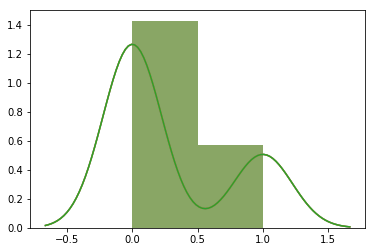

In [11]:
sns.distplot(y)
plt.show()

### Hierarchical clustering

In [8]:
def heatmap(X, row_method,
            column_method, row_metric, column_metric,
            color_gradient):
    
    print("\nPerforming hiearchical clustering using {} for columns and {} for rows".format(column_metric, row_metric))
        
    """
    This below code is based in large part on the protype methods:
    http://old.nabble.com/How-to-plot-heatmap-with-matplotlib--td32534593.html
    http://stackoverflow.com/questions/7664826/how-to-get-flat-clustering-corresponding-to-color-clusters-in-the-dendrogram-cre

    x is an m by n ndarray, m observations, n genes
    """
    
    ### Define variables
    x = np.array(X)
    column_header = column_header = ['T'+str(dataset) for dataset in list(X)] # X.columns.values
    row_header = ['A'+str(model) for model in list(X.index)] # X.index
    
    ### Define the color gradient to use based on the provided name
    n = len(x[0]); m = len(x)
    if color_gradient == 'red_white_blue':
        cmap=pylab.cm.bwr
    if color_gradient == 'red_black_sky':
        cmap=RedBlackSkyBlue()
    if color_gradient == 'red_black_blue':
        cmap=RedBlackBlue()
    if color_gradient == 'red_black_green':
        cmap=RedBlackGreen()
    if color_gradient == 'yellow_black_blue':
        cmap=YellowBlackBlue()
    if color_gradient == 'seismic':
        cmap=pylab.cm.seismic
    if color_gradient == 'green_white_purple':
        cmap=pylab.cm.PiYG_r
    if color_gradient == 'coolwarm':
        cmap=pylab.cm.coolwarm

    ### Scale the max and min colors so that 0 is white/black
    vmin=x.min()
    vmax=x.max()
    vmax = max([vmax,abs(vmin)])
    # vmin = vmax*-1
    # norm = mpl.colors.Normalize(vmin/2, vmax/2) ### adjust the max and min to scale these colors
    norm = mpl.colors.Normalize(vmin, vmax)
    ### Scale the Matplotlib window size
    default_window_hight = 8.5
    default_window_width = 12
    fig = pylab.figure(figsize=(default_window_width,default_window_hight)) ### could use m,n to scale here
    color_bar_w = 0.015 ### Sufficient size to show
        
    ## calculate positions for all elements
    # ax1, placement of dendrogram 1, on the left of the heatmap
    #if row_method != None: w1 = 
    [ax1_x, ax1_y, ax1_w, ax1_h] = [0.05,0.22,0.2,0.6]   ### The second value controls the position of the matrix relative to the bottom of the view
    width_between_ax1_axr = 0.004
    height_between_ax1_axc = 0.004 ### distance between the top color bar axis and the matrix
    
    # axr, placement of row side colorbar
    [axr_x, axr_y, axr_w, axr_h] = [0.31,0.1,color_bar_w,0.6] ### second to last controls the width of the side color bar - 0.015 when showing
    axr_x = ax1_x + ax1_w + width_between_ax1_axr
    axr_y = ax1_y; axr_h = ax1_h
    width_between_axr_axm = 0.004

    # axc, placement of column side colorbar
    [axc_x, axc_y, axc_w, axc_h] = [0.4,0.63,0.5,color_bar_w] ### last one controls the hight of the top color bar - 0.015 when showing
    axc_x = axr_x + axr_w + width_between_axr_axm
    axc_y = ax1_y + ax1_h + height_between_ax1_axc
    height_between_axc_ax2 = 0.004

    # axm, placement of heatmap for the data matrix
    [axm_x, axm_y, axm_w, axm_h] = [0.4,0.9,2.5,0.5]
    axm_x = axr_x + axr_w + width_between_axr_axm
    axm_y = ax1_y; axm_h = ax1_h
    axm_w = axc_w

    # ax2, placement of dendrogram 2, on the top of the heatmap
    [ax2_x, ax2_y, ax2_w, ax2_h] = [0.3,0.72,0.6,0.15] ### last one controls hight of the dendrogram
    ax2_x = axr_x + axr_w + width_between_axr_axm
    ax2_y = ax1_y + ax1_h + height_between_ax1_axc + axc_h + height_between_axc_ax2
    ax2_w = axc_w

    # axcb - placement of the color legend
    [axcb_x, axcb_y, axcb_w, axcb_h] = [0.07,0.88,0.18,0.09]

    # Compute and plot top dendrogram
    if column_method != None:
        start_time = time.time()
        d2 = dist.pdist(x.T)
        D2 = dist.squareform(d2)
        ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h], frame_on=True)
        Y2 = sch.linkage(D2, method=column_method, metric=column_metric) ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
        Z2 = sch.dendrogram(Y2)
        ind2 = sch.fcluster(Y2,0.7*max(Y2[:,2]),'distance') ### This is the default behavior of dendrogram
        ax2.set_xticks([]) ### Hides ticks
        ax2.set_yticks([])
        time_diff = str(round(time.time()-start_time,1))
        print('Column clustering completed in {} seconds'.format(time_diff))
    else:
        ind2 = ['NA']*len(column_header) ### Used for exporting the flat cluster data
        
    # Compute and plot left dendrogram.
    if row_method != None:
        start_time = time.time()
        d1 = dist.pdist(x)
        D1 = dist.squareform(d1)  # full matrix
        ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h], frame_on=True) # frame_on may be False
        Y1 = sch.linkage(D1, method=row_method, metric=row_metric) ### gene-clustering metric - 'average', 'single', 'centroid', 'complete'
        Z1 = sch.dendrogram(Y1, orientation='right')
        ind1 = sch.fcluster(Y1,0.7*max(Y1[:,2]),'distance') ### This is the default behavior of dendrogram
        # print 'ind1', ind1
        ax1.set_xticks([]) ### Hides ticks
        ax1.set_yticks([])
        time_diff = str(round(time.time()-start_time,1))
        print('Row clustering completed in {} seconds'.format(time_diff))
    else:
        ind1 = ['NA']*len(row_header) ### Used for exporting the flat cluster data
        
    # Plot distance matrix.
    axm = fig.add_axes([axm_x, axm_y, axm_w, axm_h])  # axes for the data matrix
    xt = x
    if column_method != None:
        idx2 = Z2['leaves'] ### apply the clustering for the array-dendrograms to the actual matrix data
        xt = xt[:,idx2]
        # print 'idx2', idx2, len(idx2)
        # print 'ind2', ind2, len(ind2)
        ind2 = [ind2[i] for i in idx2]
        # ind2 = ind2[:,idx2] ### reorder the flat cluster to match the order of the leaves the dendrogram
    if row_method != None:
        idx1 = Z1['leaves'] ### apply the clustering for the gene-dendrograms to the actual matrix data
        xt = xt[idx1,:]   # xt is transformed x
        # ind1 = ind1[idx1,:] ### reorder the flat cluster to match the order of the leaves the dendrogram
        ind1 = [ind1[i] for i in idx1]
    ### taken from http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python/3011894#3011894
    # print xt
    im = axm.matshow(xt, aspect='auto', origin='lower', cmap=cmap, norm=norm) ### norm=norm added to scale coloring of expression with zero = white or black
    axm.set_xticks([]) ### Hides x-ticks
    axm.set_yticks([])

    # Add text
    new_row_header=[]
    new_column_header=[]
    for i in range(x.shape[0]):
        if row_method != None:
            if len(row_header)<100: ### Don't visualize gene associations when more than 100 rows
                axm.text(x.shape[1]-0.5, i, '  '+row_header[idx1[i]])
            new_row_header.append(row_header[idx1[i]])
        else:
            if len(row_header)<100: ### Don't visualize gene associations when more than 100 rows
                axm.text(x.shape[1]-0.5, i, '  '+row_header[i]) ### When not clustering rows
            new_row_header.append(row_header[i])
    for i in range(x.shape[1]):
        if column_method != None:
            axm.text(i, -0.9, ' '+column_header[idx2[i]], rotation=270, verticalalignment="top") # rotation could also be degrees
            new_column_header.append(column_header[idx2[i]])
        else: ### When not clustering columns
            axm.text(i, -0.9, ' '+column_header[i], rotation=270, verticalalignment="top")
            new_column_header.append(column_header[i])

    for j in range(x.shape[0]):
        if row_method != None:
            axm.text(len(new_column_header)+1, j, ' '+row_header[idx1[j]], rotation=0, verticalalignment="top") # rotation could also be degrees
            new_row_header.append(row_header[idx1[j]])
        else: ### When not clustering columns
            axm.text(len(new_column_header)+1, j, ' '+row_header[j], rotation=0, verticalalignment="top")
            new_row_header.append(row_header[j])

    # Plot colside colors
    # axc --> axes for column side colorbar
    if column_method != None:
        axc = fig.add_axes([axc_x, axc_y, axc_w, axc_h])  # axes for column side colorbar
        cmap_c = mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])
        dc = np.array(ind2, dtype=int)
        dc.shape = (1,len(ind2)) 
        im_c = axc.matshow(dc, aspect='auto', origin='lower', cmap=cmap_c)
        axc.set_xticks([]) ### Hides ticks
        axc.set_yticks([])
    
    # Plot rowside colors
    # axr --> axes for row side colorbar
    if row_method != None:
        axr = fig.add_axes([axr_x, axr_y, axr_w, axr_h])  # axes for column side colorbar
        dr = np.array(ind1, dtype=int)
        dr.shape = (len(ind1),1)
        #print ind1, len(ind1)
        cmap_r = mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])
        im_r = axr.matshow(dr, aspect='auto', origin='lower', cmap=cmap_r)
        axr.set_xticks([]) ### Hides ticks
        axr.set_yticks([])

    # Plot color legend
    axcb = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h], frame_on=False)  # axes for colorbar
    # print 'axcb', axcb
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='horizontal')
    # print cb
    axcb.set_title("colorkey")
    
    cb.set_label("Differential Expression (log2 fold)")

    ### Render the graphic
    if len(row_header)>50 or len(column_header)>50:
        pylab.rcParams['font.size'] = 5
    else:
        pylab.rcParams['font.size'] = 8

    pylab.show()


Performing hiearchical clustering using euclidean for columns and euclidean for rows


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:92: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:108: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


Column clustering completed in 0.1 seconds
Row clustering completed in 0.1 seconds


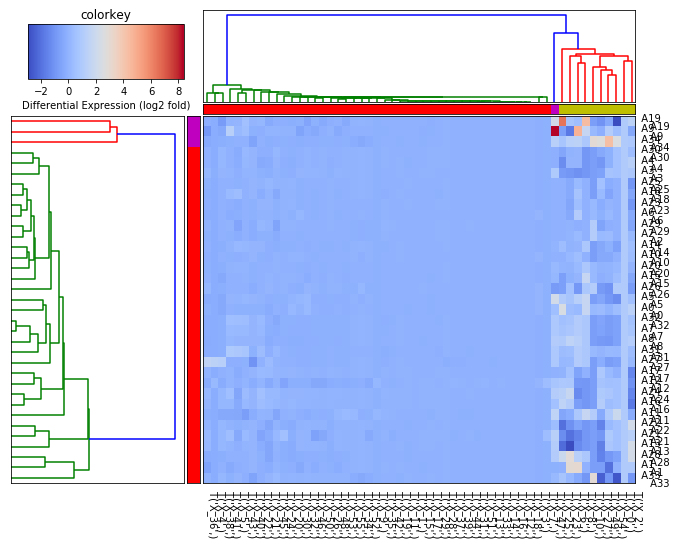

In [9]:
row_method = 'average'
column_method = 'single'
row_metric = 'euclidean'#'cityblock' #cosine
column_metric = 'euclidean'
color_gradient = 'coolwarm'#'red_white_blue
heatmap(X, row_method, column_method, row_metric, column_metric, color_gradient)

### Principal component analysis

In [10]:
def pca(X, y):
    """ Perform and plot PCA """
    
    y = np.array(y).T[0]
    target_names = ['zero', 'one'] # TODO
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    print('Explained variance ratio (first two components): {}'.format(pca.explained_variance_ratio_))

    for i, target_name in zip([0, 1], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.8, lw=2, label=target_name) # color=color,

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset')
    plt.show()

Explained variance ratio (first two components): [0.28945153 0.21634541]


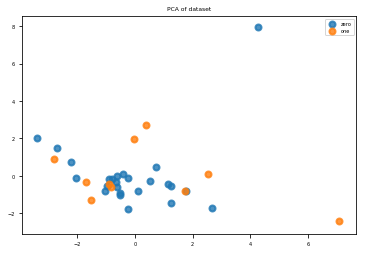

In [11]:
pca(X, y)

### Linear discriminant analysis

In [12]:
def lda(X, y):
    """ Perform and plot LDA """

    y = np.array(y).T[0]
    target_names = ['zero', 'one'] # TODO
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r = lda.fit(X, y).transform(X)

    for i, target_name in zip([0, 1], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.8, label=target_name)
    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of dataset')
    plt.show()

In [13]:
nb_classes = 2 # TODO auto
if nb_classes > 2:
    lda(X, y)

### T-SNE

In [24]:
def tsne(X, y):
    """ Perform and plot T-SNE algorithm """

    y = np.array(y).T[0]
    target_names = ['zero', 'one'] # TODO
    
    X_embedded = TSNE(n_components=2).fit_transform(X)

    for i, target_name in zip([0, 1], target_names):
        plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], alpha=.8, lw=2, label=target_name) # color=color,

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset')
    plt.show()
    

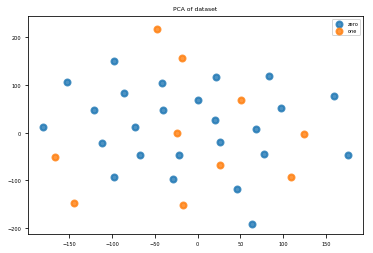

In [25]:
tsne(X, y)

### Feature selection

### Individual variable distribution

# Meta features